In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\sachur\AppData\Local\Temp\ipykernel_15112\3468321587.py:91: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1_1.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\sachur\AppData\Local\Temp\ipykernel_15112\3468321587.py:222: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1_2.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.0
1.0
1.0
1.0
1.0


C:\Users\sachur\AppData\Local\Temp\ipykernel_15112\3468321587.py:363: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2_1.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


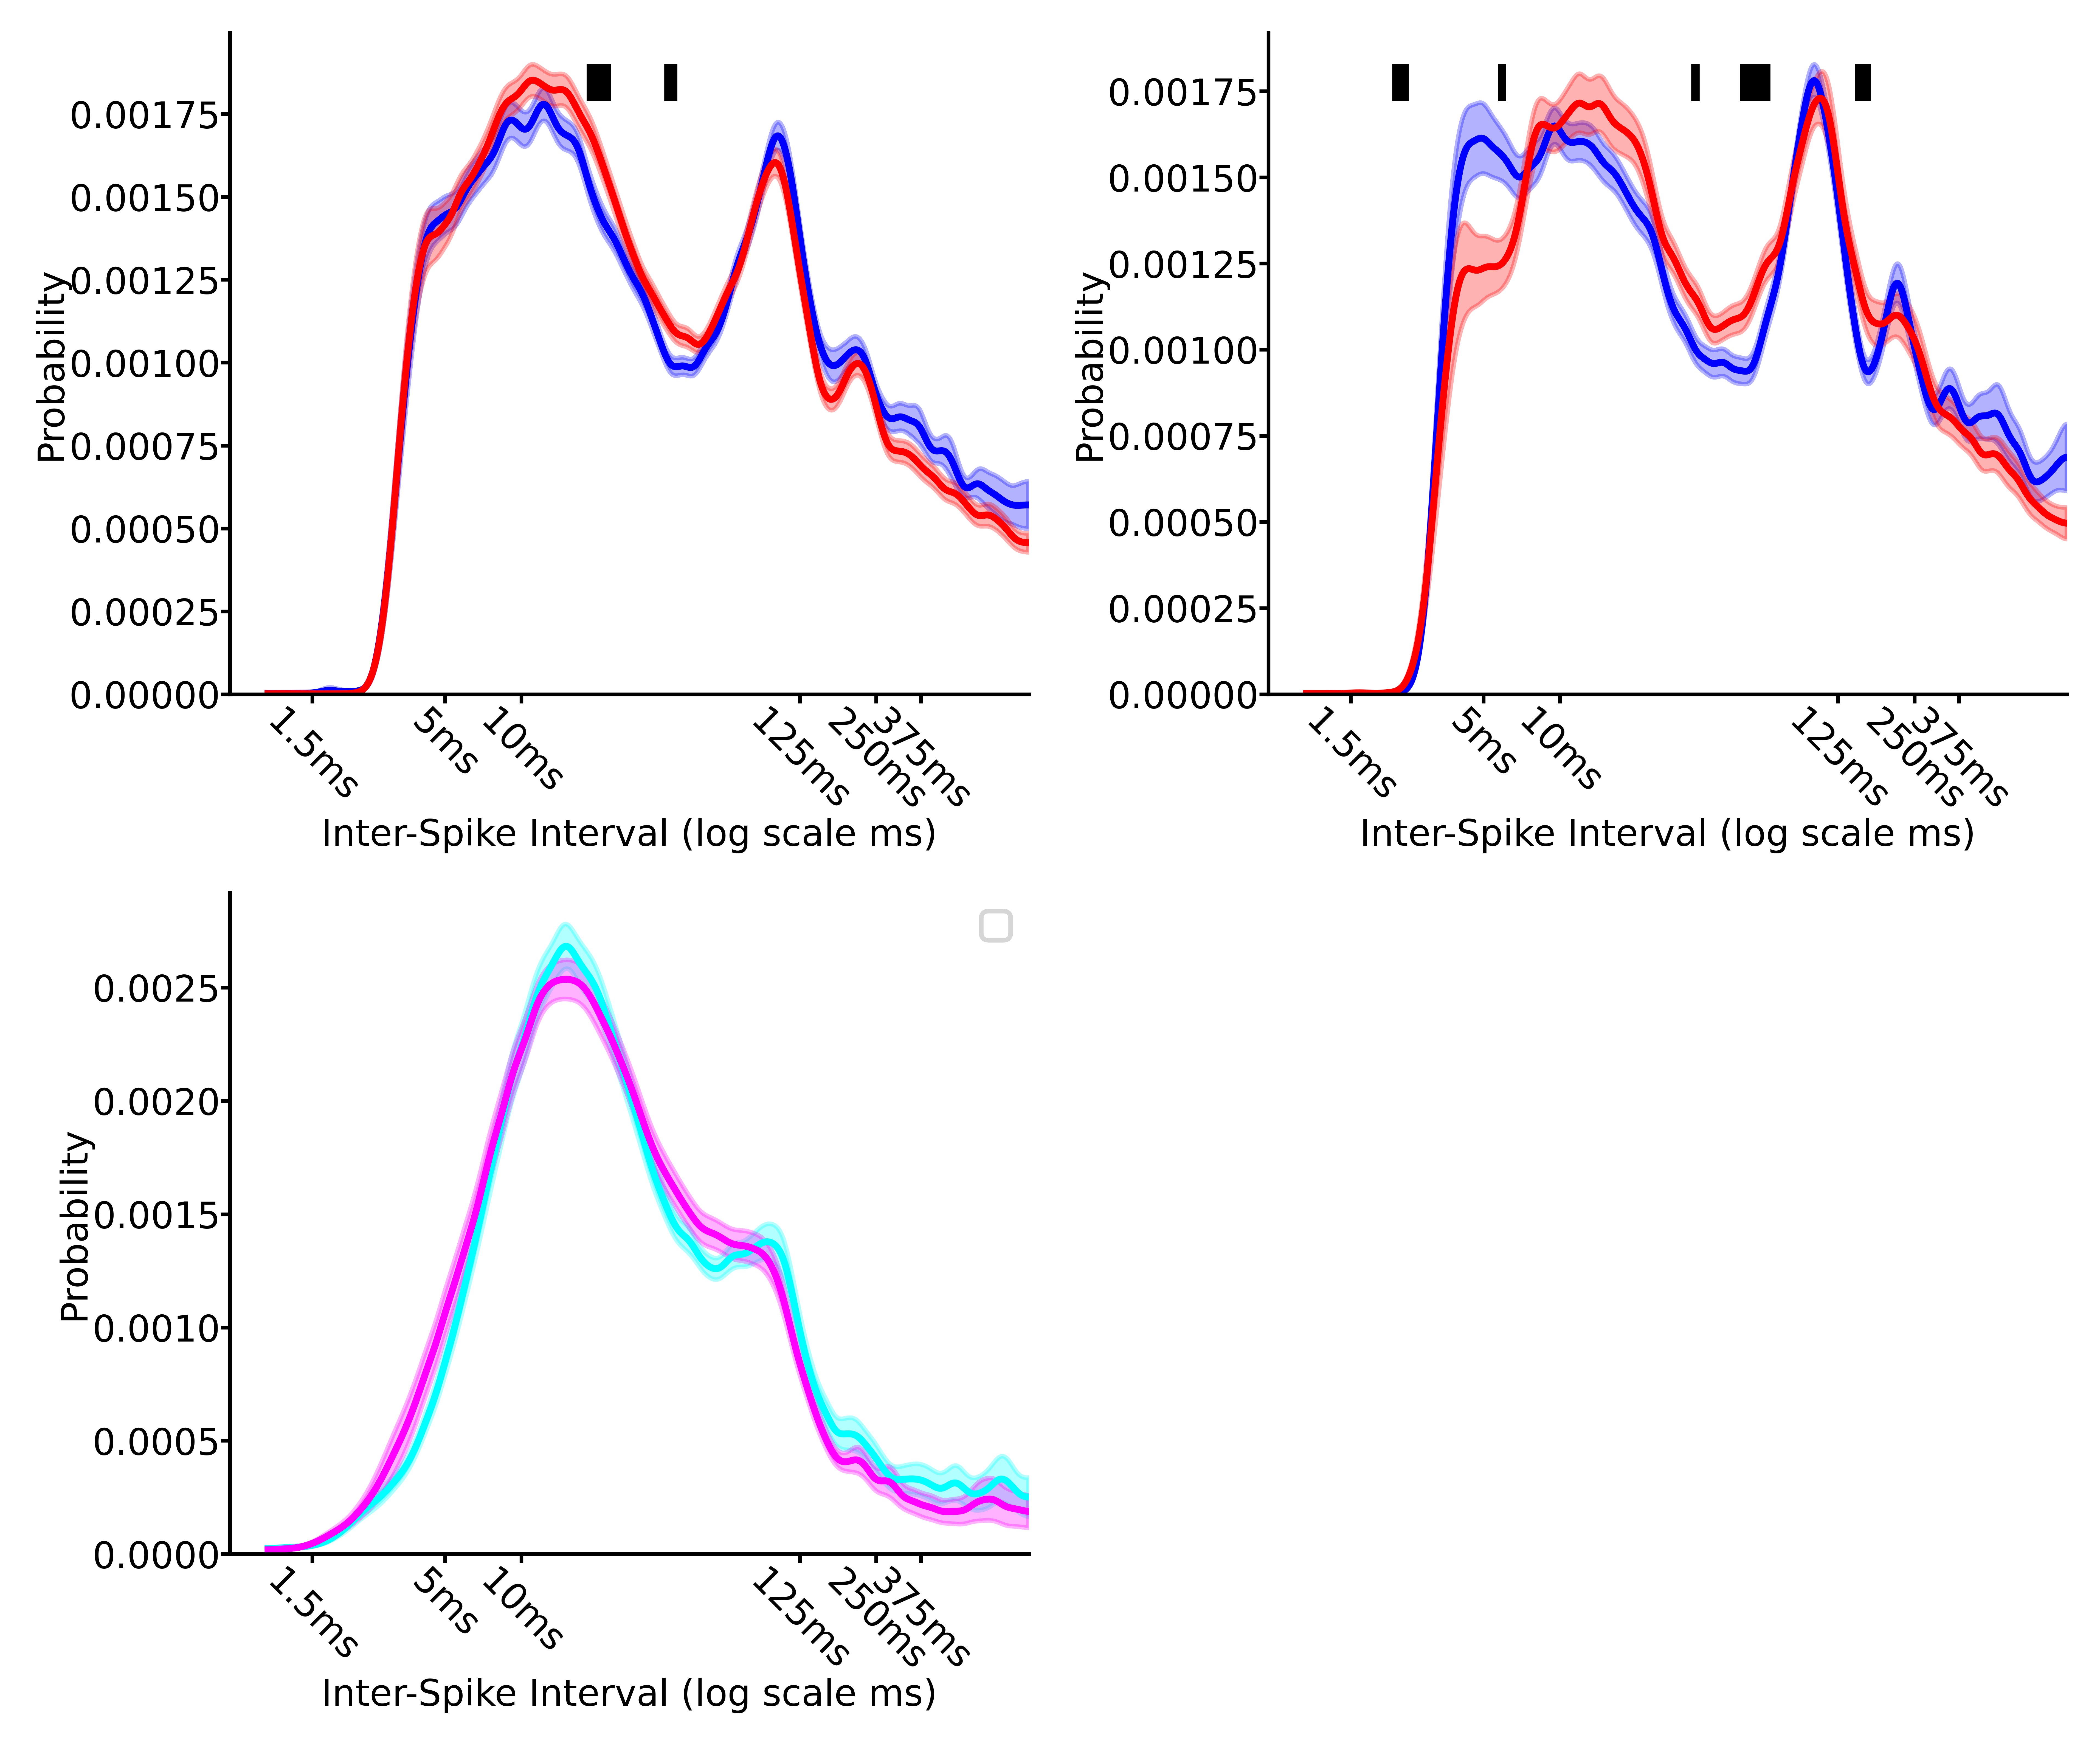

In [4]:
from calendar import c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7.2, 6),dpi=1200)
plt.rcParams.update({'font.size': 8,'font.family': 'DejaVu Sans'})
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1], width_ratios=[1,1], wspace=0.3, hspace=0.3)  # First row taller
                                                              
plt.rcParams.update({
    'axes.labelpad': 0.1,
    'ytick.major.pad': 0.1,
    'xtick.major.pad': 0.1,
    'ytick.major.size': 2,
    'xtick.major.size': 2
})

ax1_1 = fig.add_subplot(gs[0, 0])
ax1_2 = fig.add_subplot(gs[0, 1])
ax2_1 = fig.add_subplot(gs[1, 0])


df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_ko = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='deep')]
df_het = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='deep')]


# Parameters from the MATLAB function
min_isi_param = 0.001  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 10
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

def get_isihist_sm(df):
    isihist_sm_list = []
    for t in df['spike_times']:
        # Compute inter-spike intervals (ISI)
        isi = np.diff(t)
        isi = isi[isi > 0]
        if len(isi) == 0:
            continue

        # Compute histogram with 'probability' normalization
        counts, _ = np.histogram(isi, bins=edges)
        isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
        # Smooth the histogram
        isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
        isihist_sm_list.append(isihist_sm)
    return np.array(isihist_sm_list)

isihist_sm_ko = get_isihist_sm(df_ko)
isihist_sm_het = get_isihist_sm(df_het)

mean_ko = np.mean(isihist_sm_ko, axis=0)
sem_ko = np.std(isihist_sm_ko, axis=0) / np.sqrt(isihist_sm_ko.shape[0])

mean_het = np.mean(isihist_sm_het, axis=0)
sem_het = np.std(isihist_sm_het, axis=0) / np.sqrt(isihist_sm_het.shape[0])

# Plot mean curve with SEM shaded area
ax1_1.plot(time, mean_ko, color='blue')
ax1_1.fill_between(time, mean_ko - sem_ko, mean_ko + sem_ko, 
                 color='blue', alpha=0.3)
ax1_1.plot(time, mean_het, color='red')
ax1_1.fill_between(time, mean_het - sem_het, mean_het + sem_het, 
                 color='red', alpha=0.3)

# Set log scale and custom ticks for ax1_1
if log:
    ax1_1.set_xscale('log')
    tick_positions = [0.0015, 0.005, 0.01, 0.125, 0.25, 0.375]
    tick_labels = ['1.5ms', '5ms', '10ms', '125ms', '250ms', '375ms']
    ax1_1.set_xticks(tick_positions)
    ax1_1.set_xticklabels(tick_labels, rotation=-45)
    ax1_1.minorticks_off()

# Set labels and title for ax1_1
ax1_1.set_xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
ax1_1.set_ylabel('Probability')
ax1_1.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
ax1_1.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax1_1.legend().set_visible(False)
ax1_1.spines['top'].set_visible(False)
ax1_1.spines['right'].set_visible(False)
# Statistical assessment using permutation test
alpha = 0.01
M = 1000  # Number of permutations
n_ko = isihist_sm_ko.shape[0]
n_het = isihist_sm_het.shape[0]
all_hist = np.vstack((isihist_sm_ko, isihist_sm_het))
D0 = mean_ko - mean_het

rng = np.random.RandomState(42)
D_perms = np.zeros((M, len(time)))
for m in range(M):
    idx = rng.permutation(n_ko + n_het)
    perm_ko = all_hist[idx[:n_ko]]
    perm_het = all_hist[idx[n_ko:]]
    D_perms[m] = np.mean(perm_ko, 0) - np.mean(perm_het, 0)

# Pointwise bands
p_l = alpha / 2 * 100
p_u = 100 - (alpha / 2 * 100)
f_minus = np.percentile(D_perms, p_l, axis=0)
f_plus = np.percentile(D_perms, p_u, axis=0)
pointwise_sig = (D0 > f_plus) | (D0 < f_minus)

# Global bands - binary search for the largest gamma where accepted prop >= 1 - alpha
def compute_prop(gamma):
    p_l = gamma / 2 * 100
    p_u = 100 - (gamma / 2 * 100)
    g_minus = np.percentile(D_perms, p_l, axis=0)
    g_plus = np.percentile(D_perms, p_u, axis=0)
    inside = (D_perms >= g_minus) & (D_perms <= g_plus)
    num_inside = np.sum(np.all(inside, axis=1))
    prop = num_inside / M
    return prop

low = 1e-5
high = 0.5
tol = 1e-4
while high - low > tol:
    mid = (low + high) / 2
    prop = compute_prop(mid)
    if prop >= 1 - alpha:
        low = mid
    else:
        high = mid
gamma_global = low

# Compute global bands
p_l = gamma_global / 2 * 100
p_u = 100 - (gamma_global / 2 * 100)
g_minus = np.percentile(D_perms, p_l, axis=0)
g_plus = np.percentile(D_perms, p_u, axis=0)
global_sig = (D0 > g_plus) | (D0 < g_minus)

# Plot significance regions (axvspan for segments)
y_min, y_max = plt.ylim()
sig_ymax = 0.01 * y_max

# Pointwise segments in orange
pointwise_sig = pointwise_sig.astype(int)
diff_p = np.diff(np.pad(pointwise_sig, (1, 1), 'constant'))
starts_p = np.where(diff_p == 1)[0] - 1
ends_p = np.where(diff_p == -1)[0] - 1
for s, e in zip(starts_p, ends_p):
    x_start = edges[s]
    x_end = edges[e + 1]
    ax1_1.axvspan(x_start, x_end, ymin=0.9, ymax=0.95, color='black', alpha=1)

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_ko = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='superficial')]
df_het = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='superficial')]

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

def get_isihist_sm(df):
    isihist_sm_list = []
    for t in df['spike_times']:
        # Compute inter-spike intervals (ISI)
        isi = np.diff(t)
        isi = isi[isi > 0]
        if len(isi) == 0:
            continue

        # Compute histogram with 'probability' normalization
        counts, _ = np.histogram(isi, bins=edges)
        isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
        # Smooth the histogram
        isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
        isihist_sm_list.append(isihist_sm)
    return np.array(isihist_sm_list)

isihist_sm_ko = get_isihist_sm(df_ko)
isihist_sm_het = get_isihist_sm(df_het)

mean_ko = np.mean(isihist_sm_ko, axis=0)
sem_ko = np.std(isihist_sm_ko, axis=0) / np.sqrt(isihist_sm_ko.shape[0])

mean_het = np.mean(isihist_sm_het, axis=0)
sem_het = np.std(isihist_sm_het, axis=0) / np.sqrt(isihist_sm_het.shape[0])

# Plot mean curve with SEM shaded area
ax1_2.plot(time, mean_ko, color='blue')
ax1_2.fill_between(time, mean_ko - sem_ko, mean_ko + sem_ko, 
                 color='blue', alpha=0.3)
ax1_2.plot(time, mean_het, color='red')
ax1_2.fill_between(time, mean_het - sem_het, mean_het + sem_het, 
                 color='red', alpha=0.3)

# Set log scale and custom ticks for ax1_1
if log:
    ax1_2.set_xscale('log')
    tick_positions = [0.0015, 0.005, 0.01, 0.125, 0.25, 0.375]
    tick_labels = ['1.5ms', '5ms', '10ms', '125ms', '250ms', '375ms']
    ax1_2.set_xticks(tick_positions)
    ax1_2.set_xticklabels(tick_labels, rotation=-45)
    ax1_2.minorticks_off()

# Set labels and title for ax1_1
ax1_2.set_xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
ax1_2.set_ylabel('Probability')
ax1_2.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
ax1_2.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax1_2.legend().set_visible(False)
ax1_2.spines['top'].set_visible(False)
ax1_2.spines['right'].set_visible(False)


M = 1000  # Number of permutations
n_ko = isihist_sm_ko.shape[0]
n_het = isihist_sm_het.shape[0]
all_hist = np.vstack((isihist_sm_ko, isihist_sm_het))
D0 = mean_ko - mean_het

rng = np.random.RandomState(42)
D_perms = np.zeros((M, len(time)))
for m in range(M):
    idx = rng.permutation(n_ko + n_het)
    perm_ko = all_hist[idx[:n_ko]]
    perm_het = all_hist[idx[n_ko:]]
    D_perms[m] = np.mean(perm_ko, 0) - np.mean(perm_het, 0)

# Pointwise bands
p_l = alpha / 2 * 100
p_u = 100 - (alpha / 2 * 100)
f_minus = np.percentile(D_perms, p_l, axis=0)
f_plus = np.percentile(D_perms, p_u, axis=0)
pointwise_sig = (D0 > f_plus) | (D0 < f_minus)

# Global bands - binary search for the largest gamma where accepted prop >= 1 - alpha
def compute_prop(gamma):
    p_l = gamma / 2 * 100
    p_u = 100 - (gamma / 2 * 100)
    g_minus = np.percentile(D_perms, p_l, axis=0)
    g_plus = np.percentile(D_perms, p_u, axis=0)
    inside = (D_perms >= g_minus) & (D_perms <= g_plus)
    num_inside = np.sum(np.all(inside, axis=1))
    prop = num_inside / M
    return prop

low = 1e-5
high = 0.5
tol = 1e-4
while high - low > tol:
    mid = (low + high) / 2
    prop = compute_prop(mid)
    if prop >= 1 - alpha:
        low = mid
    else:
        high = mid
gamma_global = low

# Compute global bands
p_l = gamma_global / 2 * 100
p_u = 100 - (gamma_global / 2 * 100)
g_minus = np.percentile(D_perms, p_l, axis=0)
g_plus = np.percentile(D_perms, p_u, axis=0)
global_sig = (D0 > g_plus) | (D0 < g_minus)

# Plot significance regions (axvspan for segments)
y_min, y_max = plt.ylim()
sig_ymax = 0.05 * y_max

# Pointwise segments in orange
pointwise_sig = pointwise_sig.astype(int)
diff_p = np.diff(np.pad(pointwise_sig, (1, 1), 'constant'))
starts_p = np.where(diff_p == 1)[0] - 1
ends_p = np.where(diff_p == -1)[0] - 1
for s, e in zip(starts_p, ends_p):
    x_start = edges[s]
    x_end = edges[e + 1]
    ax1_2.axvspan(x_start, x_end, ymin=0.9, ymax=0.95, color='black', alpha=1)
    print(y_max)



df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_ko = df_good[(df_good['buzaki_py_cell_type']=='narrow_spike_interneurons') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')]
df_het = df_good[(df_good['buzaki_py_cell_type']=='narrow_spike_interneurons') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-')]


# Parameters from the MATLAB function
min_isi_param = 0.001  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 10
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

def get_isihist_sm(df):
    isihist_sm_list = []
    for t in df['spike_times']:
        # Compute inter-spike intervals (ISI)
        isi = np.diff(t)
        isi = isi[isi > 0]
        if len(isi) == 0:
            continue

        # Compute histogram with 'probability' normalization
        counts, _ = np.histogram(isi, bins=edges)
        isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
        # Smooth the histogram
        isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
        isihist_sm_list.append(isihist_sm)
    return np.array(isihist_sm_list)

isihist_sm_ko = get_isihist_sm(df_ko)
isihist_sm_het = get_isihist_sm(df_het)

mean_ko = np.mean(isihist_sm_ko, axis=0)
sem_ko = np.std(isihist_sm_ko, axis=0) / np.sqrt(isihist_sm_ko.shape[0])

mean_het = np.mean(isihist_sm_het, axis=0)
sem_het = np.std(isihist_sm_het, axis=0) / np.sqrt(isihist_sm_het.shape[0])

# Plot mean curve with SEM shaded area
ax2_1.plot(time, mean_ko, color='cyan')
ax2_1.fill_between(time, mean_ko - sem_ko, mean_ko + sem_ko, 
                 color='cyan', alpha=0.3)
ax2_1.plot(time, mean_het, color='magenta')
ax2_1.fill_between(time, mean_het - sem_het, mean_het + sem_het, 
                 color='magenta', alpha=0.3)

# Set log scale and custom ticks for ax1_1
if log:
    ax2_1.set_xscale('log')
    tick_positions = [0.0015, 0.005, 0.01, 0.125, 0.25, 0.375]
    tick_labels = ['1.5ms', '5ms', '10ms', '125ms', '250ms', '375ms']
    ax2_1.set_xticks(tick_positions)
    ax2_1.set_xticklabels(tick_labels, rotation=-45)
    ax2_1.minorticks_off()

# Set labels and title for ax1_1
ax2_1.set_xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
ax2_1.set_ylabel('Probability')
ax2_1.set_xlim(0, max_isi_param)  # Set x-axis to start at 0
ax2_1.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax2_1.legend().set_visible(False)
ax2_1.spines['top'].set_visible(False)
ax2_1.spines['right'].set_visible(False)
# Statistical assessment using permutation test
alpha = 0.01
M = 1000  # Number of permutations
n_ko = isihist_sm_ko.shape[0]
n_het = isihist_sm_het.shape[0]
all_hist = np.vstack((isihist_sm_ko, isihist_sm_het))
D0 = mean_ko - mean_het

rng = np.random.RandomState(42)
D_perms = np.zeros((M, len(time)))
for m in range(M):
    idx = rng.permutation(n_ko + n_het)
    perm_ko = all_hist[idx[:n_ko]]
    perm_het = all_hist[idx[n_ko:]]
    D_perms[m] = np.mean(perm_ko, 0) - np.mean(perm_het, 0)

# Pointwise bands
p_l = alpha / 2 * 100
p_u = 100 - (alpha / 2 * 100)
f_minus = np.percentile(D_perms, p_l, axis=0)
f_plus = np.percentile(D_perms, p_u, axis=0)
pointwise_sig = (D0 > f_plus) | (D0 < f_minus)

# Global bands - binary search for the largest gamma where accepted prop >= 1 - alpha
def compute_prop(gamma):
    p_l = gamma / 2 * 100
    p_u = 100 - (gamma / 2 * 100)
    g_minus = np.percentile(D_perms, p_l, axis=0)
    g_plus = np.percentile(D_perms, p_u, axis=0)
    inside = (D_perms >= g_minus) & (D_perms <= g_plus)
    num_inside = np.sum(np.all(inside, axis=1))
    prop = num_inside / M
    return prop

low = 1e-5
high = 0.5
tol = 1e-4
while high - low > tol:
    mid = (low + high) / 2
    prop = compute_prop(mid)
    if prop >= 1 - alpha:
        low = mid
    else:
        high = mid
gamma_global = low

# Compute global bands
p_l = gamma_global / 2 * 100
p_u = 100 - (gamma_global / 2 * 100)
g_minus = np.percentile(D_perms, p_l, axis=0)
g_plus = np.percentile(D_perms, p_u, axis=0)
global_sig = (D0 > g_plus) | (D0 < g_minus)

# Plot significance regions (axvspan for segments)
y_min, y_max = plt.ylim()
sig_ymax = 0.01 * y_max

# Pointwise segments in orange
pointwise_sig = pointwise_sig.astype(int)
diff_p = np.diff(np.pad(pointwise_sig, (1, 1), 'constant'))
starts_p = np.where(diff_p == 1)[0] - 1
ends_p = np.where(diff_p == -1)[0] - 1
for s, e in zip(starts_p, ends_p):
    x_start = edges[s]
    x_end = edges[e + 1]
    ax2_1.axvspan(x_start, x_end, ymin=0.9, ymax=0.95, color='black', alpha=1)

plt.legend()
plt.savefig(r'Q:/sachuriga/CR_CA1_paper/Figures/suppfig7.png', transparent=True, dpi=1200, bbox_inches='tight')
plt.show()